In [1]:
import pandas as pd
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import BlipProcessor, Blip2ForConditionalGeneration
from PIL import Image
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

/Users/mandakausthubh/miniconda3/envs/VR_Project/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mandakausthubh/miniconda3/envs/VR_Project/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/mandakausthubh/miniconda3/envs/VR_Project/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <8E6D6BF5-9658-33B9-9D3C-DF587B2F99E7> /Users/mandakausthubh/miniconda3/envs/VR_Project/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def clean_path(p):
    p = str(p).strip().replace("\\", "/")
    return os.path.normpath(p)

# Loading the Question answer generated dataset:
VQA_df = pd.read_csv("generated_questions/finalDataset.csv")
VQA_df["full_image_path"] = VQA_df["full_image_path"].apply(clean_path)

VQA_df.head()

,image_id,full_image_path,question,answer
0,81+4dBN1jsL,abo-images-small/images/small/9d/9dfccb37.jpg,What shape is this?,Rectangular
1,81+4dBN1jsL,abo-images-small/images/small/9d/9dfccb37.jpg,Is it a cover?,Yes
2,81+4dBN1jsL,abo-images-small/images/small/9d/9dfccb37.jpg,What color is bottom?,Red
3,81+4dBN1jsL,abo-images-small/images/small/9d/9dfccb37.jpg,Are there multiple colors?,Yes
4,81+4dBN1jsL,abo-images-small/images/small/9d/9dfccb37.jpg,Is there a camera hole?,Yes


In [3]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('abo-images-small/images/small/b3/b368a31a.jpg',
 'Is it rectangular?',
 'You are a helpful visual question answering assistant.\nAnswer the question about the image using ONE word only.\nQuestion: Is it rectangular?\nAnswer: Yes',
 'Yes')

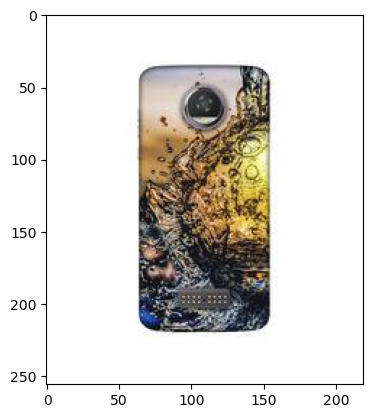

In [4]:
# Sampling and checking model usage
image_path = VQA_df["full_image_path"].iloc[203]
image = Image.open(image_path)
question = VQA_df["question"].iloc[203]
prompt = (
    "You are a helpful visual question answering assistant.\n"
    "Answer the question about the image using ONE word only.\n"
    f"Question: {question}\n"
    "Answer:"
)
answer = VQA_df["answer"].iloc[203]
inputs = processor(image, prompt, return_tensors="pt")
out = model.generate(**inputs)
prediction = processor.decode(out[0], skip_special_tokens=True).strip()

plt.imshow(image)

image_path, question, prediction, answer

In [5]:
# Extracting the answer from the output:
def extract_answer_from_prompt_output(text):
    if not isinstance(text, str):
        return None

    match = re.search(r"answer:\s*(\w+)", text, re.IGNORECASE)
    return match.group(1).strip().capitalize() if match else None

extract_answer_from_prompt_output(prediction)

'Yes'

In [6]:
# Defining a joint function for VQA_Prediction using BLIP2
def GeneratePrompt(question):
    return (
        "You are a helpful visual question answering assistant.\n"
        "Answer the question about the image using ONE word only.\n"
        f"Question: {question}\n"
        "Answer:"
    )

def GetPredictionFromImagePathandQuestion(image_path, question, prompt_generation = GeneratePrompt):
    image = Image.open(image_path)
    prompt = prompt_generation(question)
    inputs = processor(image, prompt, return_tensors="pt")
    out = model.generate(**inputs)
    prediction = processor.decode(out[0], skip_special_tokens=True).strip()

    return extract_answer_from_prompt_output(prediction)


GetPredictionFromImagePathandQuestion(image_path, question)

'Yes'

In [7]:
print("Running inference...")

predictions = []
original_answers = []
count_correct = 0

# VQA_df = VQA_df.iloc[:100]
VQA_df = VQA_df.sample(n = 10000, random_state=42).reset_index(drop=True)

for idx, row in tqdm(VQA_df.iterrows(), total=len(VQA_df)):
    question = str(row["question"])
    image_path = str(row["full_image_path"])
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        predictions.append(None)
        continue
    pred = GetPredictionFromImagePathandQuestion(image_path, question)
    predictions.append(pred.lower().strip())
    original_answers.append(row["answer"].lower().strip())
    if pred.lower().strip() == row["answer"].lower().strip():
        count_correct += 1

Running inference...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it]


In [8]:
f1_macro = f1_score(original_answers, predictions, average='macro')
f1_micro = f1_score(original_answers, predictions, average='micro')
f1_weighted = f1_score(original_answers, predictions, average='weighted')

In [9]:
f1_macro, f1_micro, f1_weighted

(0.13333333333333333, 0.3, 0.3)

In [10]:
!pip install bert-score
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
from bert_score import score

P, R, F1 = score(predictions, original_answers, lang="en", rescale_with_baseline=True)
print(f"Avg BERTScore F1: {F1.mean().item():.4f}")
print(f"Avg BERTScore Precision: {F1.mean().item():.4f}")
print(f"Avg BERTScore Recall: {F1.mean().item():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Avg BERTScore F1: 0.9656
Avg BERTScore Precision: 0.9656
Avg BERTScore Recall: 0.9656


In [15]:
import evaluate

bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=original_answers, max_order=1)
print("BLEU Score:", results)

/Users/mandakausthubh/miniconda3/envs/VR_Project/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/mandakausthubh/miniconda3/envs/VR_Project/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to u

BLEU Score: {'bleu': 0.3, 'precisions': [0.3], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 10, 'reference_length': 10}


In [19]:
from transformers import BartForConditionalGeneration, BartTokenizer

def compute_bart_score(predictions, references, tokenizer, model, device):
    scores = {"precision": [], "recall": [], "f1": []}
    
    for pred, ref in zip(predictions, references):
        # Tokenize inputs
        pred_tokens = tokenizer(pred, return_tensors="pt", padding=True, truncation=True).to(device)
        ref_tokens = tokenizer(ref, return_tensors="pt", padding=True, truncation=True).to(device)
        
        # Precision: P(ref|pred)
        with torch.no_grad():
            outputs = model(input_ids=pred_tokens["input_ids"], labels=ref_tokens["input_ids"])
            precision_score = -outputs.loss.item()
        
        # Recall: P(pred|ref)
        with torch.no_grad():
            outputs = model(input_ids=ref_tokens["input_ids"], labels=pred_tokens["input_ids"])
            recall_score = -outputs.loss.item()
        
        # F1 score
        f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score + 1e-10)
        
        scores["precision"].append(precision_score)
        scores["recall"].append(recall_score)
        scores["f1"].append(f1_score)
    
    # Average scores
    avg_scores = {key: sum(val) / len(val) for key, val in scores.items()}
    return avg_scores, scores

# Load BART model and tokenizer
model_name = "facebook/bart-large"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Run BARTScore
avg_bart_scores, individual_bart_scores = compute_bart_score(
    predictions, original_answers, tokenizer, model, device
)
print("\nAverage BARTScore:", avg_bart_scores)
# print("Individual BARTScores:", individual_bart_scores)



Average BARTScore: {'precision': -6.815693116188049, 'recall': -6.32432701587677, 'f1': -6.246258450939009}
